<a href="https://colab.research.google.com/github/ParthN9i4/ML-using-TenSEAL/blob/main/Enc_BreastCancer_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tenseal

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 15.7 MB/s eta 0:00:00


In [ ]:
import tenseal as ts

context = ts.context(ts.SCHEME_TYPE.CKKS, poly_modulus_degree = 4096, plain_modulus = 1032193)
print(context)

In [ ]:
import torch
import tenseal as ts
import pandas as pd
import random
from time import time

# those are optional and are not necessary for training
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
#Set random seeds to initialize the model weight of the model
torch.random.manual_seed(73)
random.seed(73)

def split_train_test(x, y, test_ratio=0.3, random_state=0):
    # And test set
    idxs = [i for i in range(len(x))]
    random.seed(random_state)  # Set the random seed
    random.shuffle(idxs)
    # Delimiter between test and train data
    delim = int(len(x) * test_ratio)
    test_idxs, train_idxs = idxs[:delim], idxs[delim:]
    #convert y to a tensor
    return x[train_idxs], y[train_idxs], x[test_idxs], y[test_idxs]

# Assuming 'Class' is the column representing the target variable
# Replace 'Class' with the actual name of your target variable if different
target_column = 'Class'

# Load your DataFrame 'data'
data = pd.read_csv("breast_cancer.csv")

# Display class distribution
class_distribution = data[target_column].value_counts()

# Find minority and majority classes
minority_class = class_distribution.idxmin()
majority_class = class_distribution.idxmax()

# Print class distribution and identified minority/majority classes
print("Class distribution:")
print(class_distribution)

print("\nMinority class:", minority_class)
print("Majority class:", majority_class)


Class distribution:
0    444
1    239
Name: Class, dtype: int64

Minority class: 1
Majority class: 0


In [ ]:
import pandas as pd
from imblearn.over_sampling import SMOTE

# Assuming 'Class' is the column representing the target variable
# Replace 'Class' with the actual name of your target variable if different
target_column = 'Class'

# Load your DataFrame 'data'
data = pd.read_csv("breast_cancer.csv")  # Replace with your dataset path

# Display class distribution before oversampling
print("Class distribution before oversampling:")
print(data[target_column].value_counts())

# Separate features (X) and target variable (y)
X = data.drop(target_column, axis=1)
y = data[target_column]

# Initialize SMOTE with desired sampling strategy
# In this case, 'minority' indicates that we want to oversample the minority class
smote = SMOTE(sampling_strategy='minority', random_state=42)

# Apply SMOTE to the dataset
X_resampled, y_resampled = smote.fit_resample(X, y)

# Concatenate the resampled data to create the oversampled DataFrame
oversampled_data = pd.concat([pd.DataFrame(X_resampled, columns=X.columns), pd.Series(y_resampled, name=target_column)], axis=1)

# Display class distribution after oversampling
print("\nClass distribution after oversampling:")
print(oversampled_data[target_column].value_counts())

# Triple the size by repeating the process
oversampled_data_tripled = oversampled_data.copy()
for _ in range(2):
    X_resampled, y_resampled = smote.fit_resample(oversampled_data.drop(target_column, axis=1), oversampled_data[target_column])
    oversampled_data = pd.concat([pd.DataFrame(X_resampled, columns=X.columns), pd.Series(y_resampled, name=target_column)], axis=1)
    oversampled_data_tripled = pd.concat([oversampled_data_tripled, oversampled_data], ignore_index=True)

# Display class distribution after tripling the size
print("\nClass distribution after tripling the size:")
print(oversampled_data_tripled[target_column].value_counts())


Class distribution before oversampling:
0    444
1    239
Name: Class, dtype: int64

Class distribution after oversampling:
0    444
1    444
Name: Class, dtype: int64

Class distribution after tripling the size:
0    1332
1    1332
Name: Class, dtype: int64


In [ ]:
#oversampled_data_tripled['Class'].value_counts()
df = oversampled_data_tripled
print(df['Class'].value_counts())
df.head()

0    1332
1    1332
Name: Class, dtype: int64


,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
0,5,1,1,1,2,1,3,1,1,0
1,5,4,4,5,7,10,3,2,1,0
2,3,1,1,1,2,2,3,1,1,0
3,6,8,8,1,3,4,3,7,1,0
4,4,1,1,3,2,1,3,1,1,0


In [ ]:
def breast_cancer_data():
  global df

  print(df.head())
  print(df['Class'].value_counts())
  df['Class'].replace(2,0,inplace=True)
  df['Class'].replace(4,1,inplace=True)
  grouped = df.groupby('Class')
  df = grouped.apply(lambda x: x.sample(grouped.size().min(), random_state = 73).reset_index(drop = True))
  print(df.head())
  #extract labels
  y = torch.tensor(df["Class"].values).float().unsqueeze(1)
  df = df.drop("Class", 'columns')
  #standardize data
  df = (df - df.mean()) / df.std()
  x = torch.tensor(df.values).float()
  print(df.head())
  return split_train_test(x, y)

x_train, y_train, x_test, y_test = breast_cancer_data()


featuresTrain = x_train
targetsTrain = y_train
featuresTest = x_test
targetsTest = y_test

print("############# Data summary #############")
print(f"x_train has shape: {x_train.shape}")
print(f"y_train has shape: {y_train.shape}")
print(f"x_test has shape: {x_test.shape}")
print(f"y_test has shape: {y_test.shape}")
print("#######################################")


   Clump Thickness  Uniformity of Cell Size  Uniformity of Cell Shape  \
0                5                        1                         1   
1                5                        4                         4   
2                3                        1                         1   
3                6                        8                         8   
4                4                        1                         1   

   Marginal Adhesion  Single Epithelial Cell Size  Bare Nuclei  \
0                  1                            2            1   
1                  5                            7           10   
2                  1                            2            2   
3                  1                            3            4   
4                  3                            2            1   

   Bland Chromatin  Normal Nucleoli  Mitoses  Class  
0                3                1        1      0  
1                3                2        1      0  
2 

<ipython-input-7-b163b7f24087>:13: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df = df.drop("Class", 'columns')


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset

# Define a simple logistic regression model
class LogisticRegression(nn.Module):
    def __init__(self, input_size, output_size):
        super(LogisticRegression, self).__init__()
        self.lr = nn.Linear(input_size, output_size)

    def forward(self, x):
        out = torch.sigmoid(self.lr(x))
        return out

# Initialize model, optimizer, and loss function
input_size = featuresTrain.size(1)
output_size = 1  # Assuming binary classification
model = LogisticRegression(input_size, output_size)
optimizer = optim.SGD(model.parameters(), lr=0.01)
criterion = nn.BCELoss()

# Batch size and DataLoader
batch_size = 500
train_dataset = TensorDataset(featuresTrain, targetsTrain)
test_dataset = TensorDataset(featuresTest, targetsTest)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Training function with batching
def train(model, optimizer, criterion, train_loader, num_epochs=10):
    for epoch in range(num_epochs):
        for i, (features, labels) in enumerate(train_loader):
            optimizer.zero_grad()

            # Forward pass
            outputs = model(features)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Print loss occasionally
            if (i+1) % 10 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

# Testing function with accuracy calculation
def test(model, test_loader):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0

    with torch.no_grad():
        for features, labels in test_loader:
            outputs = model(features)
            predicted = (outputs >= 0.5).float()  # Assuming binary classification
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Test Accuracy: {accuracy:.2f}%')

# Train the model with batching
train(model, optimizer, criterion, train_loader)

# Test the model and calculate accuracy
test(model, test_loader)


Test Accuracy: 89.11%


In [ ]:
class LR(torch.nn.Module):

    def __init__(self, n_features):
        super(LR, self).__init__()
        self.lr = torch.nn.Linear(n_features, 1)

    def forward(self, x):
        out = torch.sigmoid(self.lr(x))
        return out

n_features = x_train.shape[1]
model = LR(n_features)
# use gradient descent with a learning_rate=1
optim = torch.optim.SGD(model.parameters(), lr=1)
# use Binary Cross Entropy Loss
criterion = torch.nn.BCELoss()

# parameters
poly_mod_degree = 4096
coeff_mod_bit_sizes = [40, 20, 40]
# create TenSEALContext
ctx_eval = ts.context(ts.SCHEME_TYPE.CKKS, poly_mod_degree, -1, coeff_mod_bit_sizes)
# scale of ciphertext to use
ctx_eval.global_scale = 2 ** 20
# this key is needed for doing dot-product operations
ctx_eval.generate_galois_keys()

# define the number of epochs for both plain and encrypted training
EPOCHS = 3

from time import perf_counter

t_start = perf_counter()
enc_x_test = [ts.ckks_vector(ctx_eval, x.tolist()) for x in x_test]
t_end = perf_counter()

# Calculate the elapsed time in milliseconds
elapsed_time_milliseconds = (t_end - t_start) * 1000

print(f"Encryption of the test-set took {elapsed_time_milliseconds} ms")

def train(model, optim, criterion, x, y, epochs=EPOCHS):
    for e in range(1, epochs + 1):
        optim.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optim.step()
        print(f"Loss at epoch {e}: {loss.data}")
    return model

model = train(model, optim, criterion, x_train, y_train)
def accuracy(model, x, y):
    out = model(x)
    correct = torch.abs(y - out) < 0.5
    return correct.float().mean()

plain_accuracy = accuracy(model, x_test, y_test)
print(f"Accuracy on plain test_set: {plain_accuracy}")



Encryption of the test-set took 5997.629364000005 ms
Loss at epoch 1: 0.5985201001167297
Loss at epoch 2: 0.18451660871505737
Loss at epoch 3: 0.15817533433437347
Accuracy on plain test_set: 0.96620774269104


In [ ]:
class EncryptedLR:

    def __init__(self, torch_lr):
        self.weight = torch_lr.lr.weight.data.tolist()[0]
        self.bias = torch_lr.lr.bias.data.tolist()
        # we accumulate gradients and counts the number of iterations
        self._delta_w = 0
        self._delta_b = 0
        self._count = 0

    def forward(self, enc_x):
        enc_out = enc_x.dot(self.weight) + self.bias
        enc_out = EncryptedLR.sigmoid(enc_out)
        return enc_out

    def backward(self, enc_x, enc_out, enc_y):
        out_minus_y = (enc_out - enc_y)
        self._delta_w += enc_x * out_minus_y
        self._delta_b += out_minus_y
        self._count += 1

    def update_parameters(self):
        if self._count == 0:
            raise RuntimeError("You should at least run one forward iteration")
        # update weights
        # We use a small regularization term to keep the output
        # of the linear layer in the range of the sigmoid approximation
        self.weight -= self._delta_w * (1 / self._count) + self.weight * 0.05
        self.bias -= self._delta_b * (1 / self._count)
        # reset gradient accumulators and iterations count
        self._delta_w = 0
        self._delta_b = 0
        self._count = 0

    @staticmethod
    def sigmoid(enc_x):
        return enc_x.polyval([0.5, 0.197, 0, -0.004])

    def plain_accuracy(self, x_test, y_test):
        # evaluate accuracy of the model on
        # the plain (x_test, y_test) dataset
        w = torch.tensor(self.weight)
        b = torch.tensor(self.bias)
        out = torch.sigmoid(x_test.matmul(w) + b).reshape(-1, 1)
        correct = torch.abs(y_test - out) < 0.5
        return correct.float().mean()

    def encrypt(self, context):
        self.weight = ts.ckks_vector(context, self.weight)
        self.bias = ts.ckks_vector(context, self.bias)

    def decrypt(self):
        self.weight = self.weight.decrypt()
        self.bias = self.bias.decrypt()

    def __call__(self, *args, **kwargs):
        return self.forward(*args, **kwargs)

# parameters
poly_mod_degree = 8192
coeff_mod_bit_sizes = [40, 21, 21, 21, 21, 21, 21, 40]
# create TenSEALContext
ctx_training = ts.context(ts.SCHEME_TYPE.CKKS, poly_mod_degree, -1, coeff_mod_bit_sizes)
ctx_training.global_scale = 2 ** 21
ctx_training.generate_galois_keys()

t_start = time()
enc_x_train = [ts.ckks_vector(ctx_training, x.tolist()) for x in x_train]
enc_y_train = [ts.ckks_vector(ctx_training, y.tolist()) for y in y_train]
t_end = time()
print(f"Encryption of the training_set took {int(t_end - t_start)} seconds")

normal_dist = lambda x, mean, var: np.exp(- np.square(x - mean) / (2 * var)) / np.sqrt(2 * np.pi * var)

def plot_normal_dist(mean, var, rmin=-10, rmax=10):
    x = np.arange(rmin, rmax, 0.01)
    y = normal_dist(x, mean, var)
    fig = plt.plot(x, y)

# plain distribution
lr = LR(n_features)
data = lr.lr(x_test)
mean, var = map(float, [data.mean(), data.std() ** 2])
plot_normal_dist(mean, var)
print("Distribution on plain data:")
plt.show()

# encrypted distribution
def encrypted_out_distribution(eelr, enc_x_test):
    w = eelr.weight
    b = eelr.bias
    data = []
    for enc_x in enc_x_test:
        enc_out = enc_x.dot(w) + b
        data.append(enc_out.decrypt())
    data = torch.tensor(data)
    mean, var = map(float, [data.mean(), data.std() ** 2])
    plot_normal_dist(mean, var)
    print("Distribution on encrypted data:")
    plt.show()

eelr = EncryptedLR(lr)
eelr.encrypt(ctx_training)
encrypted_out_distribution(eelr, enc_x_train)

eelr = EncryptedLR(LR(n_features))
accuracy = eelr.plain_accuracy(x_test, y_test)
print(f"Accuracy at epoch #0 is {accuracy}")

times = []
for epoch in range(3):
    eelr.encrypt(ctx_training)

    # if you want to keep an eye on the distribution to make sure
    # the function approxiamation is still working fine
    # WARNING: this operation is time consuming
    # encrypted_out_distribution(eelr, enc_x_train)

    t_start = time()
    for enc_x, enc_y in zip(enc_x_train, enc_y_train):
        enc_out = eelr.forward(enc_x)
        eelr.backward(enc_x, enc_out, enc_y)
    eelr.update_parameters()
    t_end = time()
    times.append(t_end - t_start)

    eelr.decrypt()
    accuracy = eelr.plain_accuracy(x_test, y_test)
    print(f"Accuracy at epoch #{epoch + 1} is {accuracy}")

print(f"\nAverage time per epoch: {int(sum(times) / len(times))} seconds")
print(f"Final accuracy is {accuracy}")

diff_accuracy = plain_accuracy - accuracy
print(f"Difference between plain and encrypted accuracies: {diff_accuracy}")
if diff_accuracy < 0:
    print("Oh! We got a better accuracy when training on encrypted data! The noise was on our side...")


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-10-9ff75078d462>", line 68, in <cell line: 68>
    enc_x_train = [ts.ckks_vector(ctx_training, x.tolist()) for x in x_train]
  File "<ipython-input-10-9ff75078d462>", line 68, in <listcomp>
    enc_x_train = [ts.ckks_vector(ctx_training, x.tolist()) for x in x_train]
  File "/usr/local/lib/python3.10/dist-packages/tenseal/__init__.py", line 102, in ckks_vector
    return CKKSVector(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/tenseal/tensors/ckksvector.py", line 42, in __init__
    self.data = ts._ts_cpp.CKKSVector(context.data, vector)
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2099, in

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-10-9ff75078d462>", line 68, in <cell line: 68>
    enc_x_train = [ts.ckks_vector(ctx_training, x.tolist()) for x in x_train]
  File "<ipython-input-10-9ff75078d462>", line 68, in <listcomp>
    enc_x_train = [ts.ckks_vector(ctx_training, x.tolist()) for x in x_train]
  File "/usr/local/lib/python3.10/dist-packages/tenseal/__init__.py", line 102, in ckks_vector
    return CKKSVector(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/tenseal/tensors/ckksvector.py", line 42, in __init__
    self.data = ts._ts_cpp.CKKSVector(context.data, vector)
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2099, in

TypeError: object of type 'NoneType' has no len()

In [ ]:
import psutil

In [ ]:
import resource
from time import perf_counter
import matplotlib.pyplot as plt
import psutil

# Function to print resource usage
def print_resource_usage():
    print("Resource usage:")
    print(resource.getrusage(resource.RUSAGE_SELF))
    print("CPU usage:", psutil.cpu_percent(), "%")
    print("Memory usage:", psutil.virtual_memory().percent, "%")
    print("")

# Initialize lists to store resource usage data
cpu_peak_usage = []
cpu_average_usage = []
memory_peak_usage = []
memory_average_usage = []
epoch_numbers = []

# Get resource usage before encryption
print_resource_usage()

# parameters
poly_mod_degree = 4096
coeff_mod_bit_sizes = [40, 20, 40]

# create TenSEALContext
ctx_eval = ts.context(ts.SCHEME_TYPE.CKKS, poly_mod_degree, -1, coeff_mod_bit_sizes)

# scale of ciphertext to use
ctx_eval.global_scale = 2 ** 20

# this key is needed for doing dot-product operations
ctx_eval.generate_galois_keys()

# define the number of epochs for both plain and encrypted training
EPOCHS = 3

# Encrypt the test set
for epoch in range(EPOCHS):
    t_start = perf_counter()
    enc_x_test = [ts.ckks_vector(ctx_eval, x.tolist()) for x in x_test]
    t_end = perf_counter()

    # Calculate elapsed time
    elapsed_time_milliseconds = (t_end - t_start) * 1000

    # Append resource usage data
    cpu_peak_usage.append(psutil.cpu_percent())
    cpu_average_usage.append(psutil.cpu_percent(interval=1))
    memory_peak_usage.append(psutil.virtual_memory().percent)
    memory_average_usage.append(psutil.virtual_memory().percent)
    epoch_numbers.append(epoch)

    # Print resource usage after each epoch
    print(f"After epoch {epoch + 1}:")
    print_resource_usage()


Resource usage:
resource.struct_rusage(ru_utime=1435.470612, ru_stime=10.716048, ru_maxrss=5269224, ru_ixrss=0, ru_idrss=0, ru_isrss=0, ru_minflt=1253094, ru_majflt=2709, ru_nswap=0, ru_inblock=574600, ru_oublock=24, ru_msgsnd=0, ru_msgrcv=0, ru_nsignals=0, ru_nvcsw=495346, ru_nivcsw=288934)
CPU usage: 11.5 %
Memory usage: 48.6 %

After epoch 1:
Resource usage:
resource.struct_rusage(ru_utime=1438.956519, ru_stime=10.773732, ru_maxrss=5289820, ru_ixrss=0, ru_idrss=0, ru_isrss=0, ru_minflt=1258298, ru_majflt=2709, ru_nswap=0, ru_inblock=574600, ru_oublock=24, ru_msgsnd=0, ru_msgrcv=0, ru_nsignals=0, ru_nvcsw=496109, ru_nivcsw=291080)
CPU usage: 100.0 %
Memory usage: 48.9 %

After epoch 2:
Resource usage:
resource.struct_rusage(ru_utime=1441.958918, ru_stime=10.810596, ru_maxrss=5289820, ru_ixrss=0, ru_idrss=0, ru_isrss=0, ru_minflt=1258299, ru_majflt=2709, ru_nswap=0, ru_inblock=574600, ru_oublock=24, ru_msgsnd=0, ru_msgrcv=0, ru_nsignals=0, ru_nvcsw=496644, ru_nivcsw=292153)
CPU usage:

Batch 1:
Resource usage:
resource.struct_rusage(ru_utime=2363.495565, ru_stime=15.188427, ru_maxrss=5301444, ru_ixrss=0, ru_idrss=0, ru_isrss=0, ru_minflt=1261127, ru_majflt=2709, ru_nswap=0, ru_inblock=574728, ru_oublock=24, ru_msgsnd=0, ru_msgrcv=0, ru_nsignals=0, ru_nvcsw=810482, ru_nivcsw=471163)
CPU usage: 0.0 %
Memory usage: 47.4 %

Encryption of batch 1 took 26 seconds

Batch 2:
Resource usage:
resource.struct_rusage(ru_utime=2376.067194, ru_stime=15.252332, ru_maxrss=5301444, ru_ixrss=0, ru_idrss=0, ru_isrss=0, ru_minflt=1261127, ru_majflt=2709, ru_nswap=0, ru_inblock=574728, ru_oublock=24, ru_msgsnd=0, ru_msgrcv=0, ru_nsignals=0, ru_nvcsw=812441, ru_nivcsw=473244)
CPU usage: 0.0 %
Memory usage: 47.6 %

Encryption of batch 2 took 12 seconds

Batch 3:
Resource usage:
resource.struct_rusage(ru_utime=2389.243349, ru_stime=15.312294, ru_maxrss=5301444, ru_ixrss=0, ru_idrss=0, ru_isrss=0, ru_minflt=1261127, ru_majflt=2709, ru_nswap=0, ru_inblock=574728, ru_oublock=24, ru_msgsnd=0, r

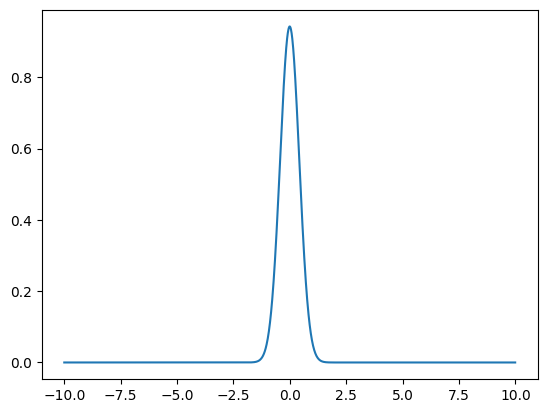

Distribution on encrypted data:


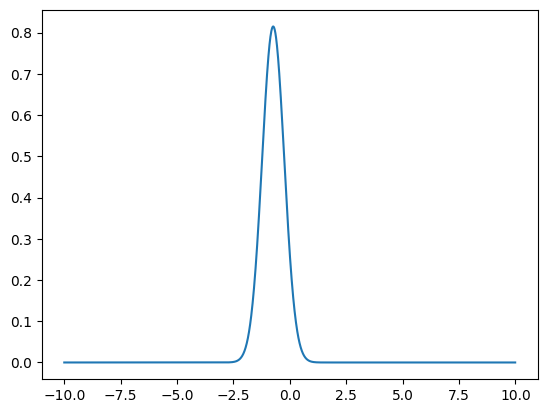

Accuracy at epoch #0 is 0.7609511613845825
before testing: 
Resource usage:
resource.struct_rusage(ru_utime=2521.070319, ru_stime=15.867457, ru_maxrss=5304348, ru_ixrss=0, ru_idrss=0, ru_isrss=0, ru_minflt=1261888, ru_majflt=2709, ru_nswap=0, ru_inblock=574728, ru_oublock=24, ru_msgsnd=0, ru_msgrcv=0, ru_nsignals=0, ru_nvcsw=846428, ru_nivcsw=499538)
CPU usage: 66.4 %
Memory usage: 46.7 %

after testing at epoch #1: 
Resource usage:
resource.struct_rusage(ru_utime=2763.939652, ru_stime=16.598747, ru_maxrss=5304612, ru_ixrss=0, ru_idrss=0, ru_isrss=0, ru_minflt=1261967, ru_majflt=2709, ru_nswap=0, ru_inblock=574728, ru_oublock=24, ru_msgsnd=0, ru_msgrcv=0, ru_nsignals=0, ru_nvcsw=904480, ru_nivcsw=544366)
CPU usage: 65.3 %
Memory usage: 46.6 %

Accuracy at epoch #1 is 0.9624530673027039
after testing at epoch #2: 
Resource usage:
resource.struct_rusage(ru_utime=3005.71915, ru_stime=17.31707, ru_maxrss=5304612, ru_ixrss=0, ru_idrss=0, ru_isrss=0, ru_minflt=1261970, ru_majflt=2709, ru_nsw

In [ ]:
import math

class EncryptedLR:

    def __init__(self, torch_lr):
        self.weight = torch_lr.lr.weight.data.tolist()[0]
        self.bias = torch_lr.lr.bias.data.tolist()
        # we accumulate gradients and counts the number of iterations
        self._delta_w = 0
        self._delta_b = 0
        self._count = 0

    def forward(self, enc_x):
        enc_out = enc_x.dot(self.weight) + self.bias
        enc_out = EncryptedLR.sigmoid(enc_out)
        return enc_out

    def backward(self, enc_x, enc_out, enc_y):
        out_minus_y = (enc_out - enc_y)
        self._delta_w += enc_x * out_minus_y
        self._delta_b += out_minus_y
        self._count += 1

    def update_parameters(self):
        if self._count == 0:
            raise RuntimeError("You should at least run one forward iteration")
        # update weights
        # We use a small regularization term to keep the output
        # of the linear layer in the range of the sigmoid approximation
        self.weight -= self._delta_w * (1 / self._count) + self.weight * 0.05
        self.bias -= self._delta_b * (1 / self._count)
        # reset gradient accumulators and iterations count
        self._delta_w = 0
        self._delta_b = 0
        self._count = 0

    @staticmethod
    def sigmoid(enc_x):
        return enc_x.polyval([0.5, 0.197, 0, -0.004])

    def plain_accuracy(self, x_test, y_test):
        # evaluate accuracy of the model on
        # the plain (x_test, y_test) dataset
        w = torch.tensor(self.weight)
        b = torch.tensor(self.bias)
        out = torch.sigmoid(x_test.matmul(w) + b).reshape(-1, 1)
        correct = torch.abs(y_test - out) < 0.5
        return correct.float().mean()

    def encrypt(self, context):
        self.weight = ts.ckks_vector(context, self.weight)
        self.bias = ts.ckks_vector(context, self.bias)

    def decrypt(self):
        self.weight = self.weight.decrypt()
        self.bias = self.bias.decrypt()

    def __call__(self, *args, **kwargs):
        return self.forward(*args, **kwargs)



# parameters
poly_mod_degree = 8192
coeff_mod_bit_sizes = [40, 21, 21, 21, 21, 21, 21, 40]
# create TenSEALContext
ctx_training = ts.context(ts.SCHEME_TYPE.CKKS, poly_mod_degree, -1, coeff_mod_bit_sizes)
ctx_training.global_scale = 2 ** 21
ctx_training.generate_galois_keys()

# Initialize lists to store resource usage data for each epoch/batch
cpu_usages = []
memory_usages = []
enc_x_train = []
enc_y_train = []
# Define the batch size
batch_size = 500

# Calculate the total number of batches
num_batches = math.ceil(len(x_train) / batch_size)

# Encryption of the training set with batching
for i in range(num_batches):
    t_start = perf_counter()  # Record start time for each batch

    start_idx = i * batch_size
    end_idx = min((i + 1) * batch_size, len(x_train))  # Adjust end index for the last batch

    # Extract a batch of data
    batch_x = x_train[start_idx:end_idx]
    batch_y = y_train[start_idx:end_idx]

    # Encrypt the batch
    enc_x_batch = [ts.ckks_vector(ctx_training, x.tolist()) for x in batch_x]
    enc_y_batch = [ts.ckks_vector(ctx_training, y.tolist()) for y in batch_y]

    # Append the batch to the encrypted training set
    enc_x_train.extend(enc_x_batch)
    enc_y_train.extend(enc_y_batch)

    t_end = perf_counter()  # Record end time for each batch

    # Append CPU and memory usage data for each batch
    cpu_usages.append(psutil.cpu_percent())
    memory_usages.append(psutil.virtual_memory().percent)

    print(f"Batch {i+1}:")
    print_resource_usage()
    print(f"Encryption of batch {i+1} took {int(t_end - t_start)} seconds\n")

normal_dist = lambda x, mean, var: np.exp(- np.square(x - mean) / (2 * var)) / np.sqrt(2 * np.pi * var)

def plot_normal_dist(mean, var, rmin=-10, rmax=10):
    x = np.arange(rmin, rmax, 0.01)
    y = normal_dist(x, mean, var)
    fig = plt.plot(x, y)

# plain distribution
lr = LR(n_features)
data = lr.lr(x_test)
mean, var = map(float, [data.mean(), data.std() ** 2])
plot_normal_dist(mean, var)
print("Distribution on plain data:")
plt.show()

# encrypted distribution
def encrypted_out_distribution(eelr, enc_x_test):
    w = eelr.weight
    b = eelr.bias
    data = []
    for enc_x in enc_x_test:
        enc_out = enc_x.dot(w) + b
        data.append(enc_out.decrypt())
    data = torch.tensor(data)
    mean, var = map(float, [data.mean(), data.std() ** 2])
    plot_normal_dist(mean, var)
    print("Distribution on encrypted data:")
    plt.show()

eelr = EncryptedLR(lr)
eelr.encrypt(ctx_training)
encrypted_out_distribution(eelr, enc_x_train)

eelr = EncryptedLR(LR(n_features))
accuracy = eelr.plain_accuracy(x_test, y_test)
print(f"Accuracy at epoch #0 is {accuracy}")

times = []
print("before testing: ")
print_resource_usage()
for epoch in range(EPOCHS):
    eelr.encrypt(ctx_training)


    t_start = perf_counter()
    for enc_x, enc_y in zip(enc_x_train, enc_y_train):
        enc_out = eelr.forward(enc_x)
        eelr.backward(enc_x, enc_out, enc_y)
    eelr.update_parameters()
    t_end = perf_counter()
    times.append(t_end - t_start)

    eelr.decrypt()
    accuracy = eelr.plain_accuracy(x_test, y_test)

    print(f"after testing at epoch #{epoch + 1}: ")
    print_resource_usage()
    print(f"Accuracy at epoch #{epoch + 1} is {accuracy}")
print("Last print: ")
print_resource_usage()
print(f"\nAverage time per epoch: {int(sum(times) / len(times))} seconds")
print(f"Total execution time: {times} (seconds)")
print(f"Final accuracy is {accuracy}")

diff_accuracy = plain_accuracy - accuracy
print(f"Difference between plain and encrypted accuracies: {diff_accuracy}")
if diff_accuracy < 0:
    print("Oh! We got a better accuracy when training on encrypted data! The noise was on our side...")
